<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - Second Task</h2>
<h4>Gabriele Marconi<br/>Daniele Ceccarelli</h4>

In this document we will develop an <b>Image Processing routine</b> that solves the second task of
<a href="./fruit-inspection.pdf">this project</a> for every image given:
<ul>
    <li><a href="./asset/second_task/C1_000004.png">Image 04</a></li>
    <li><a href="./asset/second_task/C1_000005.png">Image 05</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./asset/second_task/C0_000004.png">NIR Image 04</a></li>
    <li><a href="./asset/second_task/C0_000005.png">NIR Image 05</a></li>
</ul>

The objective is to <b>identify the russet</b> or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

It is advised to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.
<br/><br/>
The code begins by importing all of the necessary packages.

In [1]:
from enum import Enum
import cv2
from cv2 import COVAR_NORMAL
import numpy as np
from matplotlib import pyplot as plt

In this sections we set up the code so that we could quickly switch between the images and different color spaces. <br/>
After testing the whole script with multiple color spaces, <b>RGB</b> gave the best results for most of the operations. For this reason we set RGB as the standard space to use. <br/>
However, some of these operations will require other color spaces (HSV, LAB...).<br/><br/>
For each image we empirically selected a window of pixels delimited by the variables <b>X_MIN</b>, <b>X_MAX</b>, <b>Y_MIN</b>, <b>Y_MAX</b> in order to compute the statistical quantities needed to perform the <b>Mahalanobis distance</b>, which will be defined later in the code.

In [2]:
class ColorSpace(Enum):
    RGB=0
    LUV=1
    HSL=2

class Image_num(Enum):
    IMG4=0
    IMG5=1

IMAGE=Image_num.IMG4

if(IMAGE==Image_num.IMG4):
    imgpath_ir="./asset/second_task/C0_000004.png"
    imgpath_col="./asset/second_task/C1_000004.png"
    X_MIN = 124
    X_MAX = 135
    Y_MIN = 94
    Y_MAX = 105

elif(IMAGE==Image_num.IMG5):
    imgpath_ir="./asset/second_task/C0_000005.png"
    imgpath_col="./asset/second_task/C1_000005.png"
    X_MIN = 139
    X_MAX = 144
    Y_MIN = 152
    Y_MAX = 157

COLOR_SPACE=ColorSpace.RGB

We also import both the colored image and the NIR image using <b>OpenCV</b>.<br/>
Then, we make a copy of the colored image that will be used to show the position of the selected window.

In [3]:
image=cv2.imread(imgpath_ir,cv2.IMREAD_GRAYSCALE)
img = cv2.imread(imgpath_col)
show_window_img=img.copy()

<h3>Generating a Binary Mask</h3>

As with the <a href="First_Task.ipynb">First Task</a>, we outline the fruit by generating a binary mask. <br/>
For this part we use the grayscale NIR image. <br/><br/>
In the first place, the image is thresholded by using the adaptive threshold, and then an opening operation is performed. <br/><br/>
<b><i>The function parameters were determined empirically.</i></b>

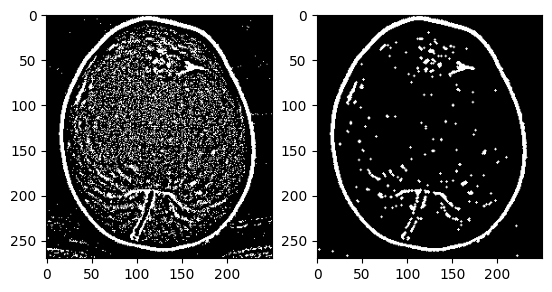

In [4]:
t_image=cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
kernel_opcl=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
opened=cv2.morphologyEx(t_image,cv2.MORPH_OPEN,kernel_opcl)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(t_image,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(opened,cmap='gray',vmin=0, vmax=255)
plt.show()

For this particular task we need two masks:
<ul>
    <li>The <b>first mask</b> will be used to outline the fruit</li>
    <li>The <b>second mask</b> will be used and explained later on</li>
</ul>
To obtain the masks we <b>find the contours</b> of the image, we order them by area size (as seen in the first task) and we take the second contour. <br/>
This is done since in these images the biggest curve (the outline of the fruit) creates an external and an internal contour.<br/>
Since the external contour is too close to the edges of the image, we take the internal contour.<br/><br/>
Using this contour we obtain the first mask by filling it and drawing it onto a blank image, while the second mask is obtained by drawing the same contour with a large thickness parameter.

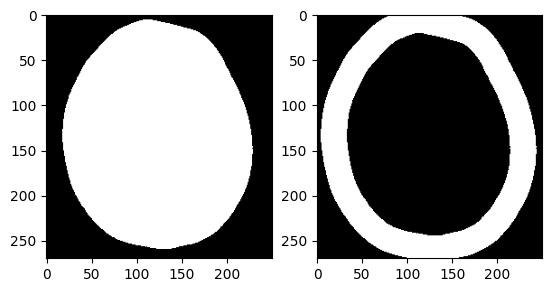

In [5]:
contours,hier=cv2.findContours(opened,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours=list(contours)
contours.sort(key=cv2.contourArea,reverse=True)
blank=np.zeros(image.shape,np.uint8)
blank2=np.zeros(image.shape,np.uint8)
cv2.drawContours(blank,contours,1,(255,255,255),-1)
cv2.drawContours(blank2,contours,1,(255,255,255),28)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(blank,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(blank2,cmap='gray',vmin=0, vmax=255)
plt.show()

We apply now the first mask on the colored image.

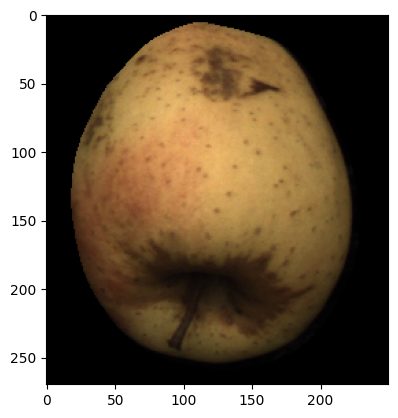

In [6]:
masked=cv2.bitwise_and(img,img,mask=blank)

temp_show=cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
plt.imshow(temp_show,vmin=0, vmax=255)
plt.show()

<h3>Identification of the russet</h3>

For this part we only use the colored image.<br/>
The identification of the russet will be performed by an <b>image segmentation</b> based on <b>analysis of colors</b> in the image itself.<br/><br/>
Since the russet is similar to the rest of the fruit in terms of color and contrast, we applied a contrast enhancing algorithm called <a href="https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html">histogram equalization</a>. <br/>
More specifically, we used the <a href="https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html#:~:text=CLAHE%20(Contrast%20Limited%20Adaptive%20Histogram%20Equalization)">Contrast Limited Adaptive Histogram Equalization</a> also called CLAHE. <br/>
The difference between the basic and the adaptive histogram equalization is that AHE considers local changes in contrast, making it more suitable for our images.

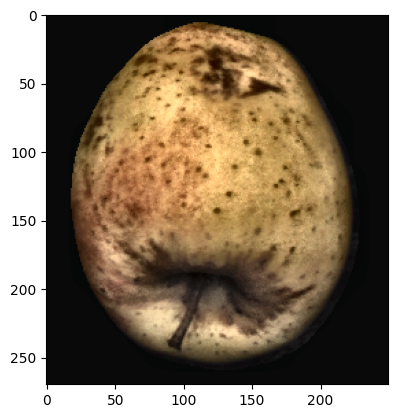

In [7]:
# converting to LAB color space
lab= cv2.cvtColor(masked, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)
# Applying CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(9,9))
cl = clahe.apply(l_channel)
# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))
# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
# Stacking the original image with the enhanced image
result = np.hstack((masked, enhanced_img))
masked=enhanced_img.copy()

temp_show=cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
plt.imshow(temp_show,vmin=0, vmax=255)
plt.show()

<h4>Mahalanobis distance</h4>
To separate the russet from the rest of the fruit we used a <b>color distance operation</b>, which consists in calculating the distance between the colors of two pixels. <br/>
In particular we used the <b>Mahalanobis distance</b> between the selected window and each of the pixels of our image. This kind of operation requires two statistical quantities:
<ul>
    <li>The <b>mean color</b> of the pixels contained in the window</li>
    <li>The <b>inverse covariance matrix</b> of the pixel colors contained in the window</li>
</ul>

For this reason the first thing we do is compute the mean color.

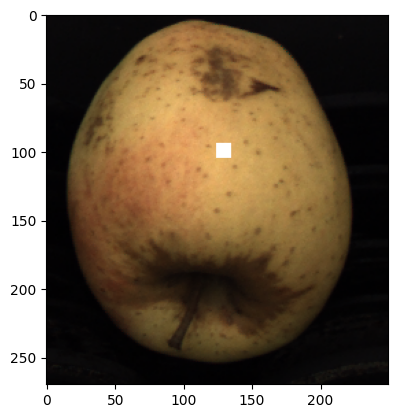

In [8]:
ch1=0
ch2=0
ch3=0
counter=0
for i in range(Y_MIN, Y_MAX):
    for j in range(X_MIN, X_MAX):
        counter=counter+1
        ch1=ch1+masked[i,j][0]
        ch2=ch2+masked[i,j][1]
        ch3=ch3+masked[i,j][2]
        show_window_img[i,j] = [255,255,255]
mean_ch1=ch1/counter
mean_ch2=ch2/counter
mean_ch3=ch3/counter     
color_pixel = np.zeros((1,1,3), dtype="uint8")
color_pixel[0][0][0] = mean_ch1
color_pixel[0][0][1] = mean_ch2
color_pixel[0][0][2] = mean_ch3

temp_show=cv2.cvtColor(show_window_img, cv2.COLOR_BGR2RGB)
plt.imshow(temp_show,vmin=0, vmax=255)
plt.show()

if (COLOR_SPACE==ColorSpace.RGB):
    mymean=cv2.cvtColor(color_pixel, cv2.COLOR_BGR2RGB)[0][0]
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
elif (COLOR_SPACE==ColorSpace.LUV):
    mymean=cv2.cvtColor(color_pixel, cv2.COLOR_BGR2Luv)[0][0]
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2Luv)
elif (COLOR_SPACE==ColorSpace.HSL):
    mymean=cv2.cvtColor(color_pixel, cv2.COLOR_BGR2HLS)[0][0]
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2HLS)

The second parameter needed for the Mahalanobis distance is the <b>inverse covariance matrix</b> of the window's pixels. <br/>
Before computing the matrix we <b>blurred the window</b> to diminish the impact of any noise inside it. <br/><br/>
Then, we compute the covariance matrix by using OpenCV's <i>calcCovarMatrix</i> and invert it using the <b>SVD Decomposition</b> method in order to obtain consistent computations even in case of a singular covariance matrix.

In [9]:
# CREATE COVAR MATRIX
cropped_selection = masked[Y_MIN:Y_MAX,X_MIN:X_MAX]

cropped_selection=cv2.medianBlur(cropped_selection, 9)


fc,sc,tc=cv2.split(cropped_selection)
fc_flat=fc.flatten()
sc_flat=sc.flatten()
tc_flat=tc.flatten()

flattened=np.array([fc_flat,sc_flat,tc_flat])
covar,mean_out=cv2.calcCovarMatrix(flattened, mean=mymean, flags=cv2.COVAR_ROWS)

# INVERT COVAR MATRIX
u,s,v=np.linalg.svd(covar, full_matrices=True)
inv_cov=np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))

The next step is to use the <a href="https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga4493aee129179459cbfc6064f051aa7d:~:text=double%20cv%3A%3A-,Mahalanobis,-("><i>Mahalanobis</i></a> function given by OpenCV.<br/>
Every pixel of our image is compared with the <b>mean color</b> of our window and the result is then saved in a new matrix at the same coordinates of the selected pixel.<br/><br/>
We essentially end up with a matrix (of the same size as the original image) that can then be used to plot the distance information.<br/><br/>
To better represent this info, a <b>colormap</b> is used to highlight <i>near</i> and <i>far</i> pixels of the whole image.<br/>
The choice of a colormap type is important, as most of them do not express the distances in a useful way for this project; in our case, we selected the <b>twilight</b> colormap.<br/><br/>
<img src="./resources/twilight.png" width="70%"> 

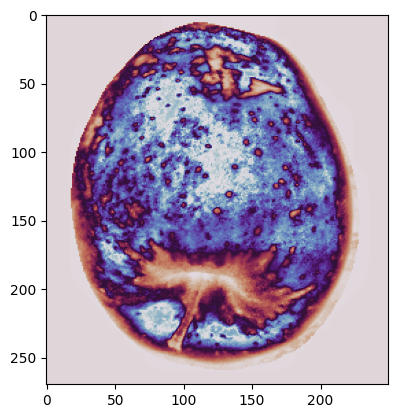

In [10]:
# CALC MAHALANOBIS DISTANCE FOR EACH PIXEL
mymean=mymean.astype(np.float32)
masked=masked.astype(np.float32)
inv_cov=inv_cov.astype(np.float32)
dist=np.zeros((masked.shape[0],masked.shape[1]),np.double)
for i, c in enumerate(masked):
    for j, k in enumerate(masked[i]):
        dist[i,j]=cv2.Mahalanobis(masked[i][j],mymean,inv_cov)

max_dist=np.max(dist)
min_dist=np.min(dist)

plt.imshow(dist, cmap='twilight',vmin=min_dist, vmax=max_dist)
plt.show()

Right now, the values inside our distance matrix are very large, so they don't translate to usual pixel values.<br/>
That is why we proportionally convert every distance into the standard pixel range, <b>from 0 to 255</b>.<br/><br/>
Next, the colormap is applied to the new matrix using the <i>applyColorMap</i> method.

In [11]:
OldRange = (max_dist - min_dist)

map_fcn=lambda x:np.uint8(((x - min_dist) * 255) / OldRange)
mapped_dist=map_fcn(dist)
mapped_dist=cv2.applyColorMap(mapped_dist,cv2.COLORMAP_TWILIGHT)

In order to distinguish the russet from the rest of the fruit, we selected <b>windows</b> so that they contain the lighter colors in the <b>palette</b> of our images.<br/>
Logically this means that, after the distance calculation, the darker parts of our image will be the farthest from the mean.<br/><br/>
At this point, after applying the colormap, the russet of the fruit has a <b>red hue</b>.<br/>
To properly isolate that specific part, we have to first convert the image to the <b>HSV</b> color space; this will make it easier to extract the proper hue.<br/><br/>
Then, by using the <i>inRange</i> function, the image is finally segmented by choosing the best range of color to extrapolate.<br/>
If we look at a HSV colormap, we can see the selected color range. <br/>

<img src="./resources/HSVColormapFunction.png" width="70%"><br/><br/>


Next, every pixel value that wasn't included in the selection is put to zero.<br/>
The resulting image has an unwanted <b>red outline</b> caused by the shadow on the fruit; we solve this by using the previously mentioned <b>second mask</b> to delete everything that is close to the border of the fruit.<br>
This fix could cause <b>false negatives</b> as it could exclude parts of the russet, however the loss is not severe.<br/><br/>
<b><i>The function parameters were determined empirically.</i></b>

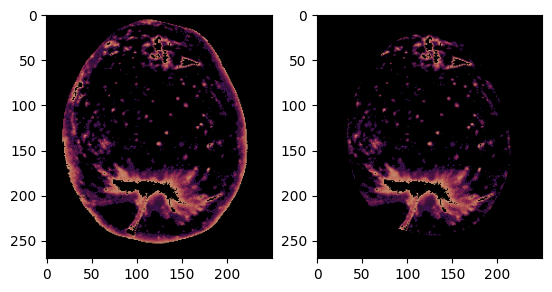

In [12]:
# inRange function works only on HSV images
mapped_dist = cv2.cvtColor(mapped_dist, cv2.COLOR_BGR2HSV)

# lower mask (0-10)
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(mapped_dist, lower_red, upper_red)

# upper mask (170-180)
lower_red = np.array([140,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(mapped_dist, lower_red, upper_red)

# join my masks
mask = mask0+mask1

# set my output img to zero everywhere except my mask
output_img = mapped_dist.copy()
output_img[np.where(mask==0)] = 0

temp_show=cv2.cvtColor(output_img, cv2.COLOR_HSV2RGB)

output_img[np.where(blank2==255)]=0

temp_show2=cv2.cvtColor(output_img, cv2.COLOR_HSV2RGB)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(temp_show,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(temp_show2,cmap='gray',vmin=0, vmax=255)
plt.show()

We now have a rough outline of all the russets, however there are <b>false positives</b> and a lot of noise.<br/>
The image is converted to <b>grayscale</b> and then thresholded using the standard <b>threshold function</b> to make the image binary.<br/><br/>
Next we apply a <b>dilation</b> followed by an <b>erosion</b>.<br/>
Usually, this just translates to a <b>Closing</b> operation, however that would mean using the same <i>kernel</i> and <i>iterations</i>.<br/>
We found the best results by dividing the two transformations and choosing different parameters for each one.<br/><br/>
The result still has <b>false positives</b>, but it's easier to work with as it has less noise.

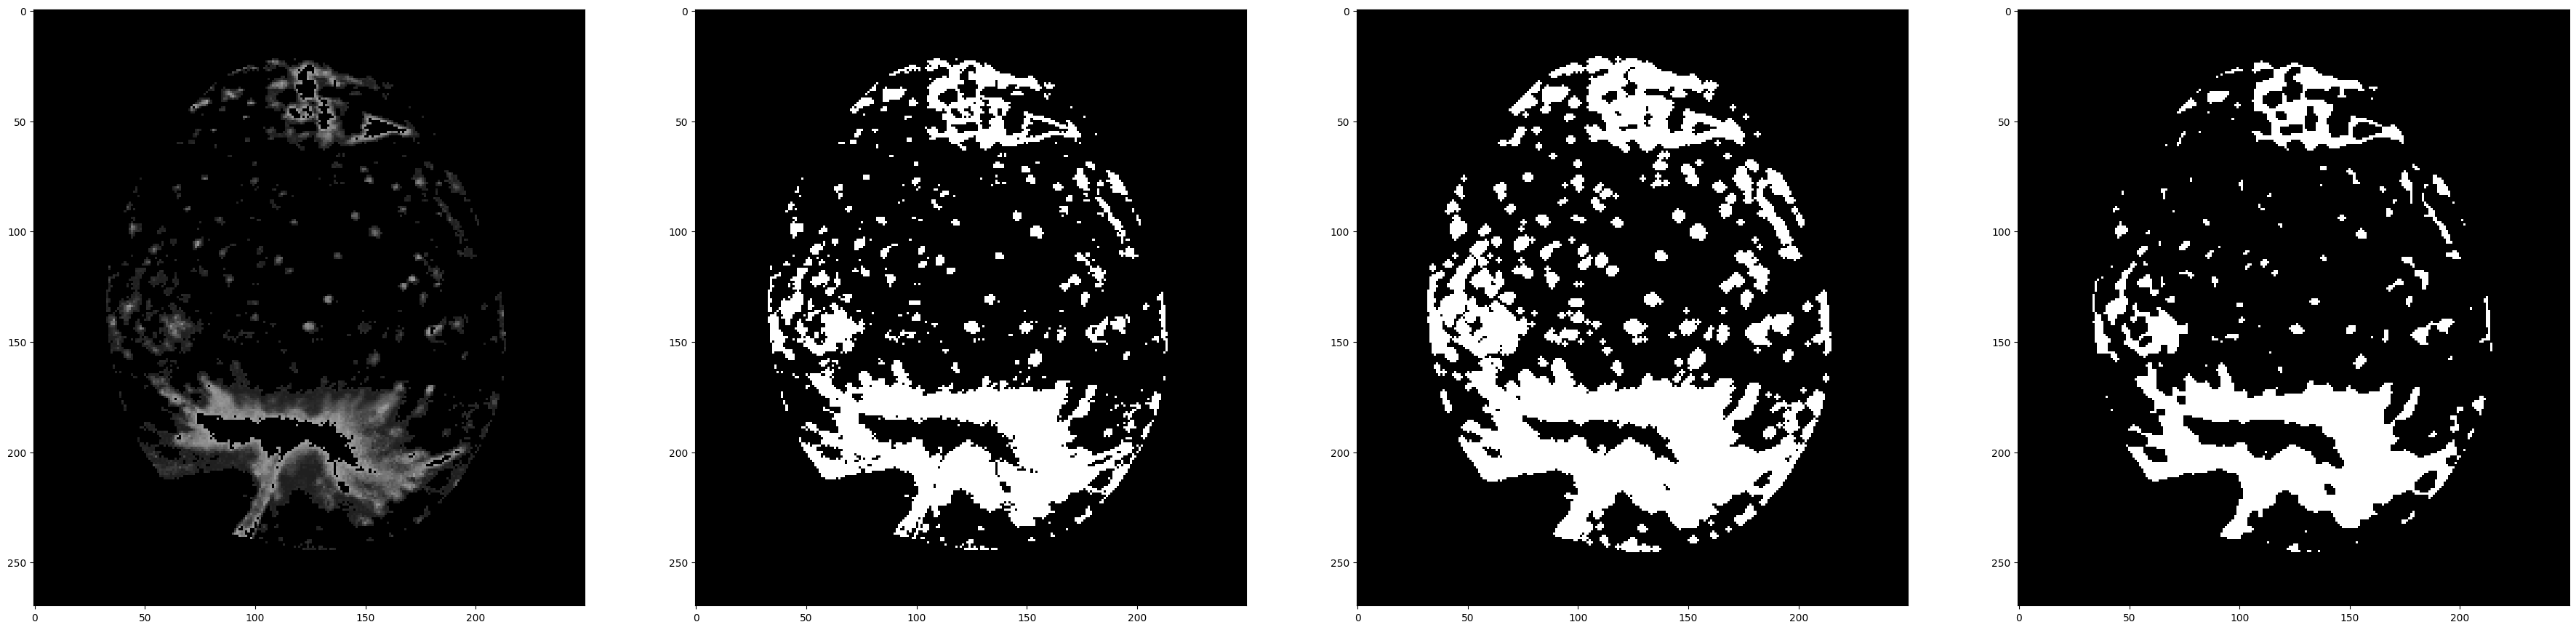

In [13]:
output_img = cv2.cvtColor(output_img, cv2.COLOR_HSV2BGR)
output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)
first = output_img.copy()

retval,output_img=cv2.threshold(output_img,1,255,cv2.THRESH_BINARY)
second = output_img.copy()

kernel_dil=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
output_img=cv2.dilate(output_img,kernel_dil,iterations=1)
third = output_img.copy()

kernel = np.ones((2,2),np.uint8)
output_img = cv2.erode(output_img,kernel,iterations = 2)
fourth = output_img.copy()

f, axarr = plt.subplots(1,4, figsize=(45,45))
axarr[0].imshow(first,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(second,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(third,cmap='gray',vmin=0, vmax=255)
axarr[3].imshow(fourth,cmap='gray',vmin=0, vmax=255)
plt.show()

To accurately identify the russets, we again introduce contours.<br/>
Starting from the last image, we find all contours and select the ones respecting the following criteria:
<ul>
    <li>The <b>area</b> of the current contour has to be greater than 350 (value chosen empirically).<br/>
    This is done to exclude contours generated by noise and dark spots on the surface of the apples.</li>
    <li>The <b>mean hue</b> inside the area of the contour relative to the original colored image fits a certain range.<br/>
    We studied the hue distribution of the images and found that a range of 0 to 22 represents the colors inside russets.<br/> This effectively removes all <b>false positives</b>.</li>
</ul>

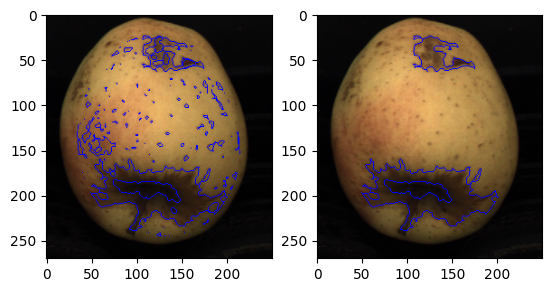

In [14]:
contours,hier=cv2.findContours(output_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours=list(contours)
contours.sort(key=cv2.contourArea,reverse=True)
blank=np.zeros(image.shape,np.uint8)

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
good_contours=[]

for i,c in enumerate(contours):
    if(cv2.contourArea(c)<350):
        continue

    blank=np.zeros(image.shape,np.uint8)
    cv2.drawContours(blank,contours,i,(255,255,255),-1)
    locs = np.where(blank == 255)
    h,s,v=cv2.split(img_hsv)
    pixels = h[locs]
    mean_h=np.mean(pixels)
    if(mean_h<23):
        good_contours.append(c)


temp_show=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.drawContours(temp_show.copy(),contours,-1,(0,0,255),1),cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(cv2.drawContours(temp_show,good_contours,-1,(0,0,255),1),cmap='gray',vmin=0, vmax=255)
plt.show()

Finally, we remove nested contours by drawing them onto a blank image and using the <i>fill</i> option of the <i>drawContours</i> function.<br/>
Then, we find all contours in the resulting image and draw them onto the colored image, obtaining the final result.

3


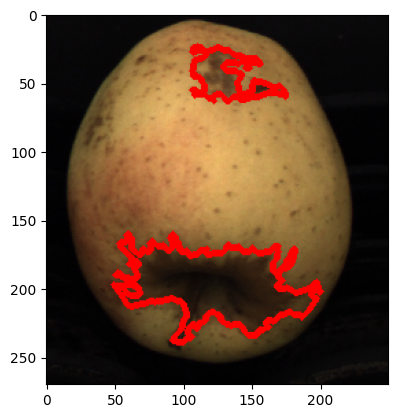

In [15]:
blank=np.zeros(image.shape,np.uint8)
print(len(good_contours))
for i,c in enumerate(good_contours):
    cv2.drawContours(blank,good_contours,i,(255,255,255),-1)


contours,hier=cv2.findContours(blank,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img,contours,-1,(0,0,255),3)

temp_show=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(temp_show,vmin=0, vmax=255)
plt.show()